<h1>Cell classification with supervised models</h1>

In [2]:
import sys
if '/home/ross/immunova' not in sys.path:
    sys.path.append('/home/ross/immunova')
from immunova.data.mongo_setup import pd_init
from immunova.data.fcs_experiments import FCSExperiment
from immunova.flow.gating.actions import Gating
from immunova.flow.gating.defaults import ChildPopulationCollection
from immunova.flow.supervised_algo.cell_classifier import create_reference_sample
from warnings import filterwarnings
from tqdm import tqdm_notebook
import matplotlib
import pandas as pd
import os
filterwarnings('ignore')
pd_init()

In [3]:
texp = FCSExperiment.objects(experiment_id='PD_T_PDMCs').get()

In [4]:
exclude = [f'{x}_pdmc_t' for x in ['209-03', '210-14', '273-01', '298-01', '322-01', '237-06', '302-01']]

In [6]:
create_reference_sample(experiment=texp,
                        root_population='single_Live_CD3+',
                        exclude=exclude,
                        sample_n=30000)

-------------------- Generating Reference Sample --------------------
Finding features common to all fcs files...
Sampling 142-09_pdmc_t...
Sampling 165-09_pdmc_t...
Sampling 175-09_pdmc_t...
Sampling 209-05_pdmc_t...
Sampling 239-02_pdmc_t...
Sampling 239-04_pdmc_t...
Sampling 251-07_pdmc_t...
Sampling 251-08_pdmc_t...
Sampling 254-04_pdmc_t...
Sampling 254-05_pdmc_t...
Sampling 255-04_pdmc_t...
Sampling 255-05_pdmc_t...
Sampling 264-02_pdmc_t...
Sampling 267-02_pdmc_t...
Sampling 276-01_pdmc_t...
Sampling 286-03_pdmc_t...
Sampling 286-04_pdmc_t...
Sampling 294-02_pdmc_t...
Sampling 294-03_pdmc_t...
Sampling 305-01_pdmc_t...
Sampling 305-03_pdmc_t...
Sampling 306-01_pdmc_t...
Sampling 308-02R_pdmc_t...
Sampling 308-03R_pdmc_t...
Sampling 308-04_pdmc_t...
Sampling 310-01_pdmc_t...
Sampling 315-01_pdmc_t...
Sampling 315-02_pdmc_t...
Sampling 318-01_pdmc_t...
Sampling 323-01_pdmc_t...
Sampling 324-01_pdmc_t...
Sampling 326-01_pdmc_t...
Sampling 267-01_pdmc_t...
Sampling 279-03_pdmc_t...


<h2>Gate the sampled data</h2>

We have a sampled dataset, a concatination of the 43 PDMC samples. I will now label this dataset to be used as training data for a supervised machine learning model that will perform multi-label classification of cells.

In [7]:
sample = Gating(texp, 'PD_T_PDMCs_sampled_data', include_controls=False)

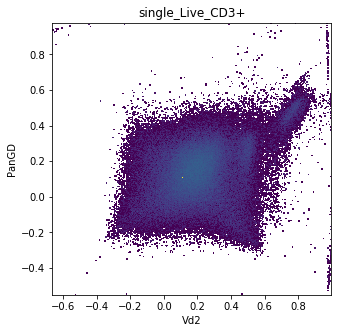

In [8]:
sample.plotting.plot_population('single_Live_CD3+', 'Vd2', 'PanGD', transforms={'x': 'logicle', 
                                                                                'y': 'logicle'})

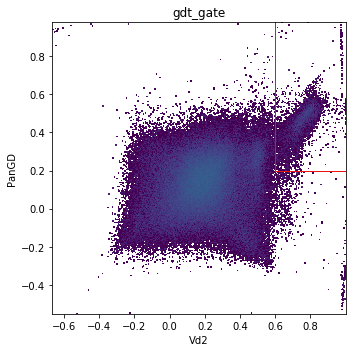

In [9]:
children = ChildPopulationCollection('geom')
children.add_population('gdt', definition='+')
children.add_population('nongdt', definition='-')
kwargs = dict(x='Vd2', y='PanGD', transform_x='logicle', transform_y='logicle',
             x_min=0.6, y_min=0.2, x_max=1, y_max=1)
sample.create_gate(gate_name='gdt_gate', 
                   parent='single_Live_CD3+',
                   class_='Static',
                   method='rect_gate',
                   child_populations=children, 
                   kwargs=kwargs)
sample.apply('gdt_gate')

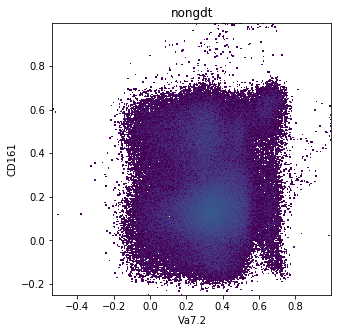

In [10]:
sample.plotting.plot_population('nongdt', 'Va7.2', 'CD161', transforms={'x': 'logicle', 'y': 'logicle'})

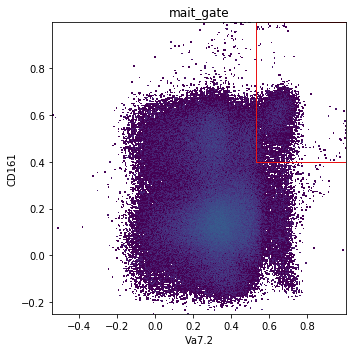

In [11]:
children = ChildPopulationCollection('geom')
children.add_population('mait', definition='+')
children.add_population('classic', definition='-')
kwargs = dict(x='Va7.2', y='CD161', transform_x='logicle', transform_y='logicle',
             x_min=0.53, y_min=0.4, x_max=1, y_max=1)
sample.create_gate(gate_name='mait_gate', 
                   parent='nongdt',
                   class_='Static',
                   method='rect_gate',
                   child_populations=children, 
                   kwargs=kwargs)
sample.apply('mait_gate')

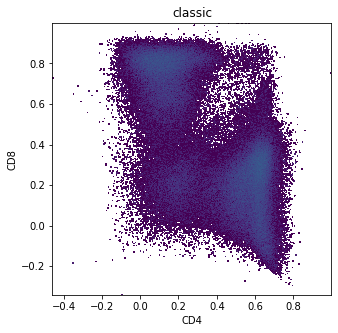

In [12]:
sample.plotting.plot_population('classic', 'CD4', 'CD8', transforms={'x': 'logicle', 'y': 'logicle'})

In [13]:
children = ChildPopulationCollection('threshold_2d')
children.add_population('CD4+CD8+', definition='++')
children.add_population('CD4-CD8-', definition='--')
children.add_population('CD4+CD8-', definition='+-')
children.add_population('CD4-CD8+', definition='-+')
kwargs = dict(x='CD4', y='CD8', transform_x='logicle', transform_y='logicle',
             threshold_x=0.42, threshold_y=0.55)
sample.create_gate(gate_name='cd4cd8_gate', 
                   parent='classic',
                   class_='Static',
                   method='threshold_2d',
                   child_populations=children, 
                   kwargs=kwargs)

True

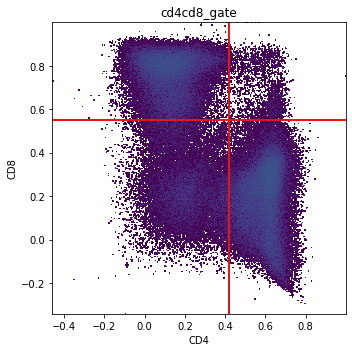

In [14]:
sample.apply('cd4cd8_gate')

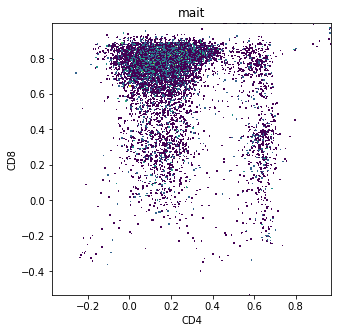

In [15]:
sample.plotting.plot_population('mait', 'CD4', 'CD8', transforms={'x': 'logicle', 'y': 'logicle'})

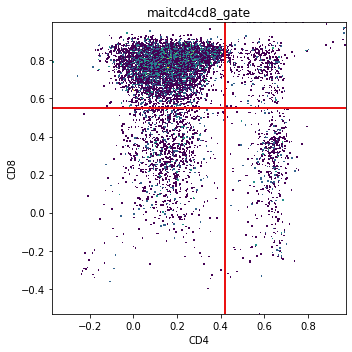

In [16]:
children = ChildPopulationCollection('threshold_2d')
children.add_population('mait+CD4+CD8+', definition='++')
children.add_population('mait+CD4-CD8-', definition='--')
children.add_population('mait+CD4+CD8-', definition='+-')
children.add_population('mait+CD4-CD8+', definition='-+')
kwargs = dict(x='CD4', y='CD8', transform_x='logicle', transform_y='logicle',
             threshold_x=0.42, threshold_y=0.55)
sample.create_gate(gate_name='maitcd4cd8_gate', 
                   parent='mait',
                   class_='Static',
                   method='threshold_2d',
                   child_populations=children, 
                   kwargs=kwargs)
sample.apply('maitcd4cd8_gate')

In [17]:
sample.save(overwrite=True)

Saved successfully!


True

<h2>Supervised learning</h2>